# Libraries

In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import random
import os
import pandas as pd
from anytree import Node, find_by_attr
from preprocessing import apply_mask_to_detected_object, \
    find_best_ground_truth_match, get_taxonomy_hierarchy

# Populate Taxonomy

In [2]:
from anytree import Node

root = Node("object", rank="root")

# Create root nodes
marine_life = Node("marine life", parent=root, rank="binary")
inanimate = Node("inanimate", parent=root, rank="binary")

# Create class nodes under the respective root nodes
asteroidea = Node("asteroidea", parent=marine_life, rank="class")
phaeophyceae = Node("phaeophyceae", parent=marine_life, rank="class")
bivalia = Node("bivalia", parent=marine_life, rank="class")
myxini = Node("myxini", parent=marine_life, rank="class")
artificial = Node("artificial", parent=inanimate, rank="class")
natural = Node("natural", parent=inanimate, rank="class")
chlorophyta = Node("chlorophyta", parent=marine_life, rank="class")
monocots = Node("monocots", parent=marine_life, rank="class")

# Create genus nodes under the respective class nodes
asterias = Node("asterias", parent=asteroidea, rank="genus")
fucus = Node("fucus", parent=phaeophyceae, rank="genus")
henrica = Node("Henrica", parent=asteroidea, rank="genus")
mya = Node("mya", parent=bivalia, rank="genus")
myxine = Node("myxine", parent=myxini, rank="genus")
cylindrical = Node("cylindrical", parent=artificial, rank="genus")
solid = Node("solid", parent=natural, rank="genus")
arboral = Node("arboral", parent=natural, rank="genus")
saccharina = Node("saccharina", parent=phaeophyceae, rank="genus")
ulva = Node("ulva", parent=chlorophyta, rank="genus")
urospora = Node("Urospora", parent=chlorophyta, rank="genus")
zostera = Node("zostera", parent=monocots, rank="genus")

# Create species nodes under the respective genus nodes
asterias_rubens = Node("asterias rubens", parent=asterias, rank="species")
fucus_vesiculosus = Node("fucus vesiculosus", parent=fucus, rank="species")
henrica_species = Node("henrica", parent=henrica, rank="species")  # Assuming "henrica" is a species
mytilus_edulis = Node("mytilus edulis", parent=mya, rank="species")
myxine_glurinosa = Node("myxine glurinosa", parent=myxine, rank="species")
pipe = Node("pipe", parent=cylindrical, rank="species")
rock = Node("rock", parent=solid, rank="species")
saccharina_latissima = Node("saccharina latissima", parent=saccharina, rank="species")
tree = Node("tree", parent=arboral, rank="species")
ulva_intestinalis = Node("ulva intestinalis", parent=ulva, rank="species")
urospora_species = Node("urospora", parent=urospora, rank="species")
zostera_marina = Node("zostera marina", parent=zostera, rank="species")

# Extract Prediction from Yolo v8

In [3]:
# Set the random seed for reproducibility
random.seed(13384)

# Path to the image directory and model weights
IMGDIR_PATH = "/mnt/RAID/datasets/label-studio/fjord/images/"
MODEL_PATH = "runs/segment/Yolov8n-seg-train/weights/best.pt"
classes_file = '/mnt/RAID/datasets/label-studio/fjord/classes.txt'

# Create a mapping from class indices to class names
class_index_to_name = {}
with open(classes_file, 'r') as file:
    for index, line in enumerate(file):
        class_name = line.strip()
        class_index_to_name[index] = class_name

# Load the YOLO model
model = YOLO(MODEL_PATH)

# Number of images to process in a batch
N = 100  # Adjust this number as needed

# Randomly select N images from the directory
image_files = random.sample(os.listdir(IMGDIR_PATH), N)
image_paths = [os.path.join(IMGDIR_PATH, img) for img in image_files if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Ensure that we have N images, reduce if the directory has fewer images
image_paths = image_paths[:min(N, len(image_paths))]

# Run the model on the batch of images
# Note: Depending on how YOLOv8 handles batch processing, you might need to adjust this part
results = model(image_paths, stream=True)

# Create Dataset

In [4]:
data = []

for result in results:
    orig_img = result.orig_img
    img_shape = orig_img.shape

    if result.boxes is not None and result.masks is not None:
        for box, mask in zip(result.boxes, result.masks):
            masked_img = apply_mask_to_detected_object(orig_img, box, mask)
            conf = box.conf
            pred = box.cls

            # Convert predicted mask to xyn format and find the best match
            predicted_mask_xyn = mask.xyn[0]
            best_class, best_iou = find_best_ground_truth_match(result, predicted_mask_xyn, img_shape)

            # Handle the case when best_class is None
            if best_class is not None:
                species_name = class_index_to_name[best_class]
                taxon_node = find_by_attr(root, species_name)
            else:
                species_name = "Unknown"
                taxon_node = None

            # Store relevant data
            entry = {
                'masked_image': masked_img,
                'confidence': conf.item(),
                'iou_with_best_gt': best_iou,
                'predicted_species': class_index_to_name[int(pred.item())],
                'species': species_name
            }

            # Add taxonomy hierarchy to the entry
            if taxon_node:
                for ancestor in reversed(taxon_node.path):
                    entry[ancestor.rank] = ancestor.name

            data.append(entry)
    else:
        print("No detections in this image.")

No detections in this image.


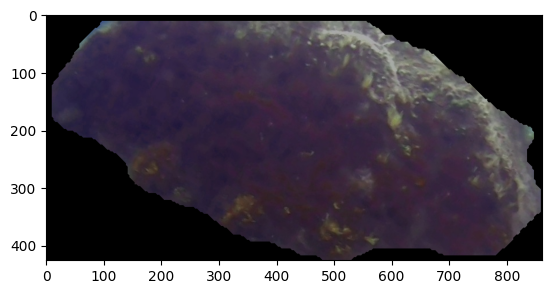

In [ ]:
plt.imshow(data[0]['masked_image'])

In [ ]:
df = pd.DataFrame(data)